In [ ]:
!pip install scikit-learn

Estimated Aleatoric Uncertainty (std): 0.78


ValueError: operands could not be broadcast together with shapes (20,) (400,) 

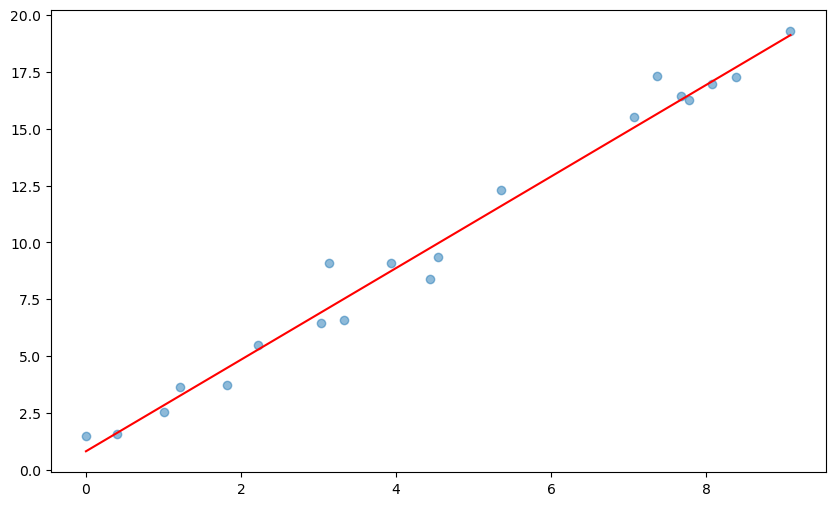

In [5]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Generate synthetic data with noise
np.random.seed(42)
X = np.linspace(0, 10, 100).reshape(-1, 1)
y = 2 * X + 1 + np.random.normal(0, 1, size=X.shape) # Add Gaussian noise

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred_mean = model.predict(X_test)

# Assume homoscedastic noise: Constant variance across all inputs
residuals = y_test - y_pred_mean
aleatoric_uncertainty = np.std(residuals)

print(f"Estimated Aleatoric Uncertainty (std): {aleatoric_uncertainty:.2f}")

# Estimate Epistemic Uncertainty

n_bootstraps = 100
bootstrapped_predictions = []

for _ in range(n_bootstraps):
  # Sample with replacement
  bootstrap_indices = np.random.choice(len(X_train), len(X_train), replace=True)
  X_bootstrap = X_train[bootstrap_indices]
  y_bootstrap = y_train[bootstrap_indices]
  
  # Train a new model on the bootstrapped data
  bootstrap_model = LinearRegression()
  bootstrap_model.fit(X_bootstrap, y_bootstrap)
  
  # Predict on the test set
  y_pred_bootstrap = bootstrap_model.predict(X_test)
  bootstrapped_predictions.append(y_pred_bootstrap)

# Calculate the variance of predictions for each test point
epistemic_uncertainty = np.std(bootstrapped_predictions, axis=0)



#Visualize Predictions and Uncertainties
# Sort for better visualization
sort_idx = np.argsort(X_test.flatten())
X_test_sorted = X_test[sort_idx]
y_pred_mean_sorted = y_pred_mean[sort_idx]
aleatoric_uncertainty_sorted = np.repeat(aleatoric_uncertainty, len(X_test))[sort_idx]
epistemic_uncertainty_sorted = epistemic_uncertainty[sort_idx]

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, label="Test Data", alpha=0.5)
plt.plot(X_test_sorted, y_pred_mean_sorted, color='red', label="Predicted Mean")
plt.fill_between(X_test_sorted.flatten(), 
                 (y_pred_mean_sorted - aleatoric_uncertainty_sorted).flatten(), 
                 (y_pred_mean_sorted + aleatoric_uncertainty_sorted).flatten(), 
                 color='orange', alpha=0.3, label="Aleatoric Uncertainty")
plt.fill_between(X_test_sorted.flatten(), 
                 (y_pred_mean_sorted - epistemic_uncertainty_sorted).flatten(), 
                 (y_pred_mean_sorted + epistemic_uncertainty_sorted).flatten(), 
                 color='blue', alpha=0.3, label="Epistemic Uncertainty")
plt.legend()
plt.xlabel("X")
plt.ylabel("y")
plt.title("Linear Regression with Aleatoric and Epistemic Uncertainties")
plt.show()
                  

In [ ]:
!pip install tf-keras

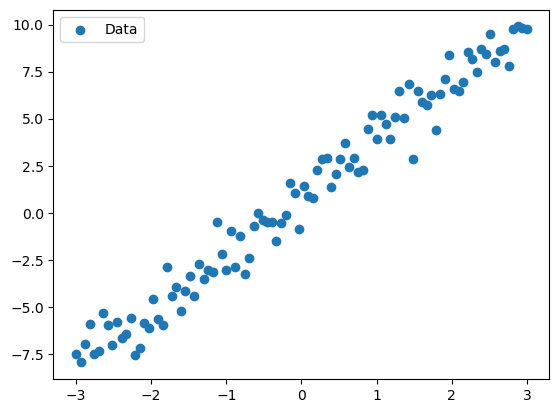

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

# Set seed for reproducibility
np.random.seed(42)

# Generate synthetic data
true_slope = 3.0
true_intercept = 1.0
num_points = 100

x = np.linspace(-3, 3, num_points)
y = true_slope * x + true_intercept + np.random.normal(0, 1, num_points)  # Adding aleatoric noise

plt.scatter(x, y, label='Data')
plt.legend()
plt.show()

In [30]:
tfd = tfp.distributions

class ProbabilisticLinearRegression(tf.keras.Model):
    def __init__(self):
        super(ProbabilisticLinearRegression, self).__init__()
        self.w_posterior = tfp.layers.DenseVariational(
            units=1,
            make_posterior_fn=self._mv_normal_fn,
            make_prior_fn=self._mv_normal_fn)
        self.b_posterior = tfp.layers.DenseVariational(
            units=1,
            make_posterior_fn=self._mv_normal_fn,
            make_prior_fn=self._mv_normal_fn)

    def _mv_normal_fn(self, shape, dtype):
        n = np.prod(shape)
        mvn = tfd.MultivariateNormalDiag(
            loc=tf.zeros(n, dtype=dtype),
            scale_diag=tf.ones(n, dtype=dtype))
        return tfd.Independent(mvn, reinterpreted_batch_ndims=tf.rank(mvn.batch_shape) - 1)

    def call(self, inputs):
        w = self.w_posterior(inputs)
        b = self.b_posterior(inputs)
        return tf.linalg.matvec(inputs, w) + b

# Convert x to required shape
x_train = x[:, np.newaxis].astype(np.float32)
y_train = y.astype(np.float32)

model = ProbabilisticLinearRegression()

negloglik = lambda y, p_y: -p_y.log_prob(y)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)

model.compile(optimizer=optimizer, loss=negloglik)

model.fit(x_train, y_train, epochs=1000, verbose=0)

# Generate test data
x_test = np.linspace(-3, 3, num_points)[:, np.newaxis].astype(np.float32)
y_true = true_slope * x_test + true_intercept

# Make predictions
y_pred_distribution = model(x_test)
y_pred_mean = y_pred_distribution.mean()
y_pred_stddev = y_pred_distribution.stddev()

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Training Data')
plt.plot(x_test, y_true, label='True Relationship', color='blue')
plt.plot(x_test, y_pred_mean, label='Predicted Mean', color='red')

# Plot aleatoric uncertainty
plt.fill_between(x_test.flatten(), 
                 y_pred_mean.numpy().flatten() - y_pred_stddev.numpy().flatten(),
                 y_pred_mean.numpy().flatten() + y_pred_stddev.numpy().flatten(),
                 color='red', alpha=0.2, label='Aleatoric Uncertainty')

# Plot epistemic uncertainty
plt.fill_between(x_test.flatten(),
                 y_pred_mean.numpy().flatten() - 2*y_pred_stddev.numpy().flatten(),
                 y_pred_mean.numpy().flatten() + 2*y_pred_stddev.numpy().flatten(),
                 color='green', alpha=0.1, label='Epistemic Uncertainty')

plt.legend()
plt.show()



TypeError: Exception encountered when calling ProbabilisticLinearRegression.call().

[1mProbabilisticLinearRegression._mv_normal_fn() takes 3 positional arguments but 4 were given[0m

Arguments received by ProbabilisticLinearRegression.call():
  • inputs=tf.Tensor(shape=(None, 1), dtype=float32)